# DINO Visualize Self-Attention Sample
https://github.com/facebookresearch/dino<br/>
https://arxiv.org/abs/2104.14294

In [1]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

In [2]:
patch_size = 8
#model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
#model = torch.hub.load('facebookresearch/dino:main', 'dino_deits8')
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

Using cache found in /home/gridsan/manderson/.cache/torch/hub/facebookresearch_dino_main


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

for p in model.parameters():
        p.requires_grad = False
        
model.eval()
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

In [4]:
print(model.blocks[0].attn.num_heads)

6


In [5]:
#for idx, module in enumerate(model.modules()):
#    print(f"Module index: {idx}, Module type: {type(module)}")

## Input Image

<class 'PIL.Image.Image'>
(768, 1024, 3)


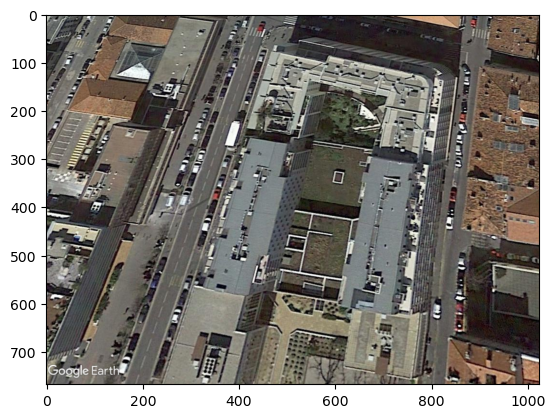

In [16]:
#response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
#img0 = Image.open(BytesIO(response.content))
#img0 = Image.open('/home/gridsan/manderson/ovdsat/figures/dino_img.png')
img0 = Image.open('/home/gridsan/manderson/ovdsat/data/simd/val/0045.jpg')
img0 = img0.convert('RGB')

plt.imshow(img0)
print(type(img0))
print(np.array(img0).shape)

## Get attention map

In [17]:
transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img0)
print(img.shape)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)
print(img.shape)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

#attentions = model.forward_selfattention(img.to(device))
attentions = model.get_last_selfattention(img)   #img.cuda()
print(attentions.shape) # spatial dimension is num of patches in image (480/30)^2 = 900 + 1 (CLS) = 901\\


torch.Size([3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 6, 3073, 3073])


In [18]:
print(dir(model))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_init_weights', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_

torch.Size([1, 3, 768, 1024])
torch.Size([1, 384])


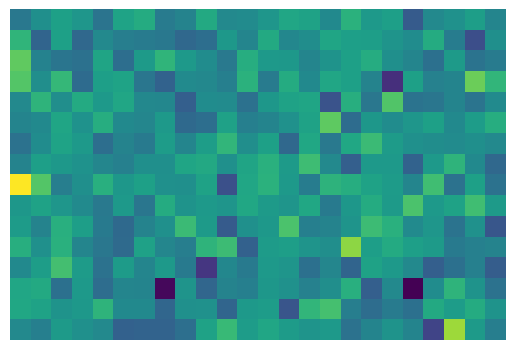

In [24]:
#output is not an attention image.
output=model(img)
print(img.shape)
print(output.shape)
plt.imshow(output.reshape(16,24))
plt.axis("off")
plt.show()

torch.Size([1, 3, 768, 1024])
torch.Size([1, 6, 3073, 3073])


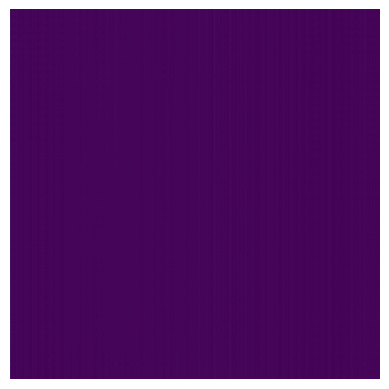

In [25]:
#get_last_selfattention
attentions = model.get_last_selfattention(img) 
print(img.shape)
print(attentions.shape)
plt.imshow(attentions[0][0].reshape(attentions.shape[2], attentions.shape[3]))
plt.axis("off")
plt.show()

In [26]:
nh = attentions.shape[1] # number of head
print(nh)

# we keep only the output patch attention (CLS attention to all other tokens)
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
print(attentions.shape)

# we keep only a certain percentage of the mass
val, idx = torch.sort(attentions)
print(val[0,:10])
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)
print(cumval[0,:10])

6
torch.Size([6, 3072])
tensor([4.6493e-05, 4.9248e-05, 5.0799e-05, 5.1475e-05, 5.2636e-05, 5.3493e-05,
        5.4170e-05, 5.4440e-05, 5.5525e-05, 5.6222e-05])
tensor([4.6958e-05, 9.6698e-05, 1.4800e-04, 1.9999e-04, 2.5316e-04, 3.0718e-04,
        3.6189e-04, 4.1688e-04, 4.7296e-04, 5.2974e-04])


torch.Size([6, 3072])
torch.Size([6, 48, 64])


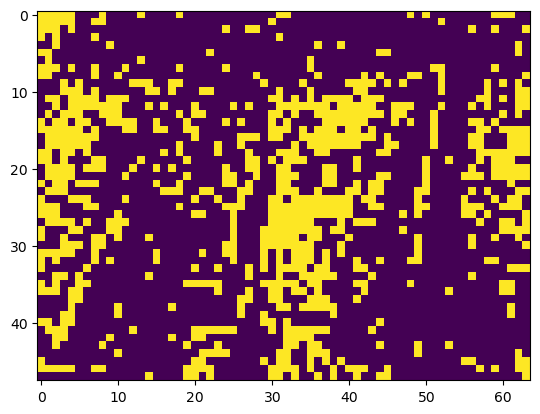

(6, 384, 512)


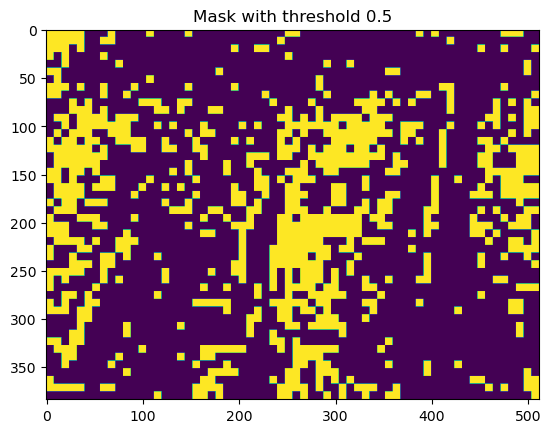

torch.Size([6, 48, 64])
(6, 384, 512)
(384, 512)


In [27]:
threshold = 0.5 # We visualize masks obtained by thresholding the self-attention maps to keep xx% of the mass.
th_attn = cumval > (1 - threshold)
idx2 = torch.argsort(idx)
for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]
    
print(th_attn.shape)
    
th_attn = th_attn.reshape(nh, w_featmap//2, h_featmap//2).float()
print(th_attn.shape)
plt.imshow(th_attn[2])
plt.show()

# interpolate
th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
print(th_attn.shape)
plt.imshow(th_attn[2])
plt.title(f'Mask with threshold {threshold}')
plt.show()

attentions = attentions.reshape(nh, w_featmap//2, h_featmap//2)
print(attentions.shape)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
print(attentions.shape)
attentions_mean = np.mean(attentions, axis=0)
print(attentions_mean.shape)

## Visualize Self-attention

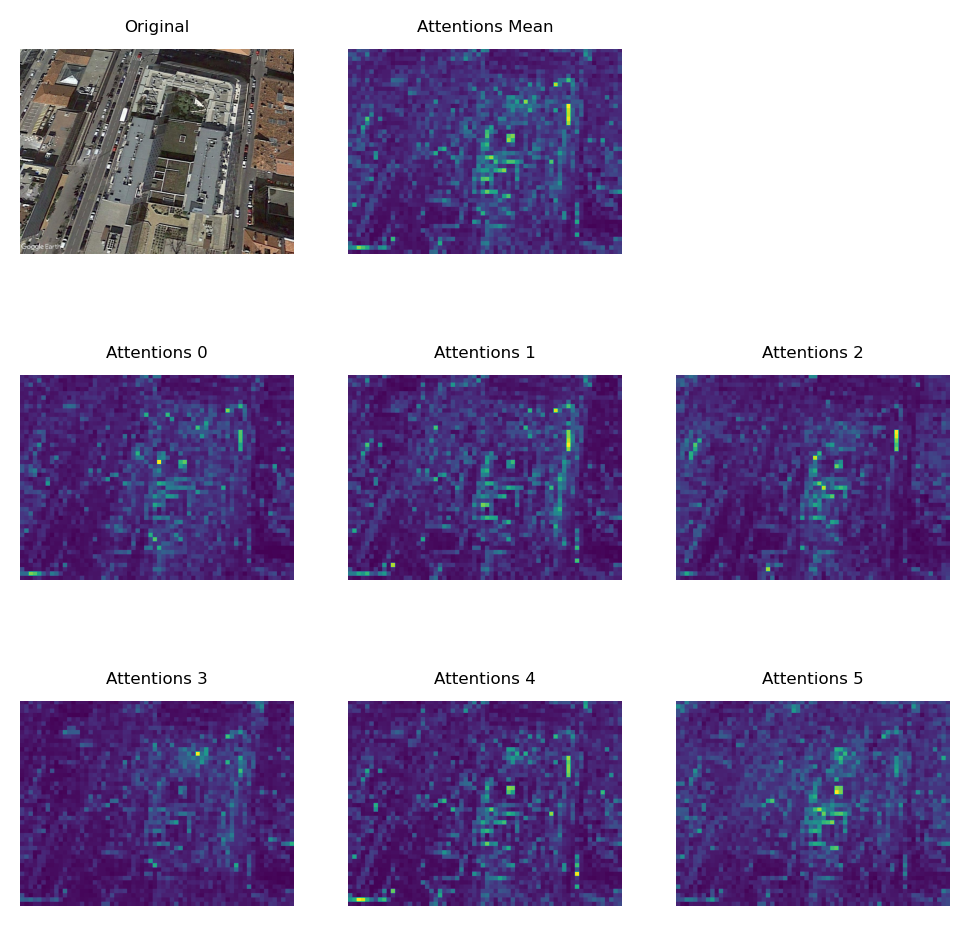

In [23]:
plt.figure(figsize=(6,6), dpi=200)

plt.subplot(3, 3, 1)
plt.title("Original",size=6)
plt.imshow(img0)
plt.axis("off")

plt.subplot(3, 3, 2)
plt.title("Attentions Mean",size=6)
plt.imshow(attentions_mean)
plt.axis("off")

for i in range(6):
    plt.subplot(3, 3, i+4)
    plt.title("Attentions "+str(i),size=6)
    plt.imshow(attentions[i])
    plt.axis("off")
